# Image Classification with PyTorch and Cleanlab


This 5-minute quickstart tutorial demonstrates how to find potential label errors in image classification data. Here we use the MNIST dataset containing 70,000 images of handwritten digits from 0 to 9.

**Overview of what we'll do in this tutorial:**

- Build a simple PyTorch neural net and wrap it with Skorch to make it scikit-learn compatible.

- Use this model to compute out-of-sample predicted probabilities, `pred_probs`, via cross-validation.

- Compute a list of potential label errors with Cleanlab's `find_label_issues` method.


## 1. Install the required dependencies


Install the following dependencies with `pip install`:

1. cleanlab
2. pandas
3. matplotlib
4. torch
5. torchvision
6. skorch


In [1]:
dependencies = ["cleanlab", "pandas", "matplotlib", "torch", "torchvision", "skorch"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/weijinglok/cleanlab.git@0f0b588cb296fb4694df3130dc3a9418bc6ae260
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")


## 2. Fetch and scale the MNIST dataset


In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy()  # 2D numpy array of image features
X /= 255.0  # Scale the features to the [0, 1] range

y = mnist.target.astype("int64").to_numpy()  # 1D numpy array of the image labels


<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Assign your data's features to variable `X` and its labels to variable `y` instead.

</div>


## 3. Define a classification model


Here, we define a simple neural network with PyTorch.


In [3]:
from torch import nn

model = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1),
)


## 4. Ensure your classifier is scikit-learn compatible


As some of Cleanlab's features requires scikit-learn compatibility, we will need to adapt the above PyTorch neural net accordingly. [Skorch](https://skorch.readthedocs.io) is a convenient package that helps with this. You can also easily wrap an arbitrary model to be scikit-learn compatible as demonstrated [here](https://github.com/cleanlab/cleanlab#use-cleanlab-with-any-model-tensorflow-pytorch-sklearn-xgboost-etc).


In [4]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(model)


## 5. Compute out-of-sample predicted probabilities


If we'd like Cleanlab to identify potential label errors in the whole dataset and not just the training set, we can consider using the entire dataset when computing the out-of-sample predicted probabilities, `pred_probs`, via cross-validation.


In [5]:
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(model_skorch, X, y, cv=3, method="predict_proba")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9575       0.7287        1.5399  0.9889


      2        1.2364       0.7975        0.9483  0.9367


      3        0.8791       0.8293        0.7197  0.9433


      4        0.7268       0.8480        0.6093  0.9452


      5        0.6398       0.8598        0.5460  0.9213


      6        0.5828       0.8695        0.5028  0.9402


      7        0.5470       0.8724        0.4728  0.9449


      8        0.5145       0.8769        0.4486  0.9215


      9        0.4919       0.8804        0.4299  0.9108


     10        0.4681       0.8838        0.4135  0.9652


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9513       0.7383        1.5183  0.9369


      2        1.2308       0.8074        0.9226  0.9155


      3        0.8769       0.8385        0.6946  0.9429


      4        0.7276       0.8580        0.5853  0.9200


      5        0.6372       0.8694        0.5203  0.9213


      6        0.5836       0.8794        0.4770  0.9663


      7        0.5449       0.8834        0.4465  0.9295


      8        0.5155       0.8894        0.4228  0.9636


      9        0.4947       0.8930        0.4041  0.9298


     10        0.4697       0.8954        0.3888  0.9305


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9645       0.7277        1.5334  0.9398


      2        1.2594       0.8070        0.9319  0.9663


      3        0.9060       0.8439        0.6992  0.9499


      4        0.7510       0.8619        0.5865  0.9477


      5        0.6641       0.8744        0.5201  1.0305


      6        0.6084       0.8811        0.4754  0.9565


      7        0.5663       0.8884        0.4438  0.9278


      8        0.5362       0.8924        0.4197  0.9245


      9        0.5100       0.8955        0.4007  0.9397


     10        0.4890       0.8999        0.3849  0.9155


## 6. Run Cleanlab to find potential label errors


Cleanlab has a `find_label_issues` function to generate a list of potential label errors. Setting `return_indices_ranked_by="self_confidence"` returns the indices of all the most likely label errors, sorted by the most suspicious example first.


In [6]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(y, pred_probs, return_indices_ranked_by="self_confidence")


## 7. Review some of the most likely mislabeled examples


In [7]:
print(f"Cleanlab found {len(ranked_label_issues)} potential label errors.")
print(f"Here are the indices of the top 15 most likely ones: \n {ranked_label_issues[:15]}")


Cleanlab found 1187 potential label errors.
Here are the indices of the top 15 most likely ones: 
 [18598 24798  8729 61790 20820 15942  1352 59915 31134 53216 55739 12679
 32776 11208 39327]


We'll define a new `plot_examples` function to display any examples in a subplot conveniently.


In [8]:
import matplotlib.pyplot as plt


def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)


Let's start by having an overview of the top 15 most likely label errors. From here, we can see a few label errors and edge cases. Feel free to change the parameters to display more or fewer examples.


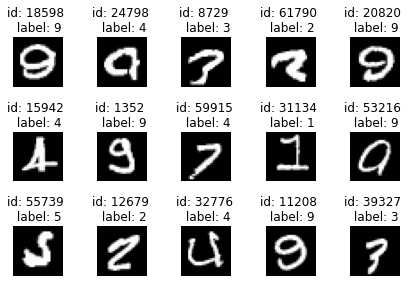

In [9]:
plot_examples(ranked_label_issues[range(15)], 3, 5)


Let's zoom into specific examples:


Given label is **4** but looks more like a **7**


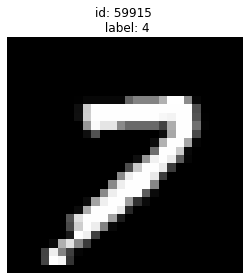

In [10]:
plot_examples([59915])


Given label is **4** but also looks like **9**


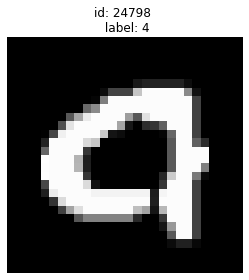

In [11]:
plot_examples([24798])


Given label is **9** but also looks like **8**

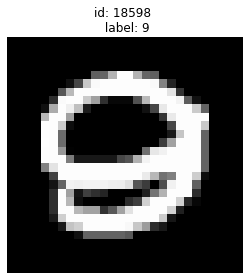

In [12]:
plot_examples([18598])


Cleanlab has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix label errors, augment edge cases, or remove obscure examples.
